In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from keras import layers
from keras.optimizers import Adam, SGD, Adagrad, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, Callback
from PIL import Image
import os
from keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [9]:
mapDict = {0: 0, 3: 1, 5: 2, 6: 3, 7: 4}

X_train = []
y_train = []
folder_path = '../Group_18/train'

for foldername in os.listdir('../Group_18/train/'):
    for filename in os.listdir(os.path.join(folder_path, foldername)):
        flattened = np.array(Image.open(os.path.join(folder_path, foldername, filename))).flatten()
        X_train.append(flattened)
        y_train.append(int(foldername))

X_train = np.array(X_train) / 255
y_train = np.array(y_train)
for i, n in enumerate(y_train):
    y_train[i] = mapDict[y_train[i]]
y_train = to_categorical(y_train, num_classes=5)

X_test = []
y_test = []

folder_path = '../Group_18/test'

for foldername in os.listdir(folder_path):
    for filename in os.listdir(os.path.join(folder_path, foldername)):
        flattened = np.array(Image.open(os.path.join(folder_path, foldername, filename))).flatten()
        X_test.append(flattened)
        y_test.append(int(foldername))

X_test = np.array(X_test) / 255
y_test = np.array(y_test)
for i, n in enumerate(y_test):
    y_test[i] = mapDict[y_test[i]]
y_test = to_categorical(y_test, num_classes=5)


X_val = []
y_val = []


folder_path = '../Group_18/val'

for foldername in os.listdir(folder_path):
    for filename in os.listdir(os.path.join(folder_path, foldername)):
        flattened = np.array(Image.open(os.path.join(folder_path, foldername, filename))).flatten()
        X_val.append(flattened)
        y_val.append(int(foldername))

X_val = np.array(X_val) / 255
y_val = np.array(y_val)
for i, n in enumerate(y_val):
    y_val[i] = mapDict[y_val[i]]
y_val = to_categorical(y_val, num_classes=5)

In [14]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)
model = keras.Sequential([
        layers.Dense(30, activation="sigmoid", name="layer1",kernel_initializer=initializer),
        layers.Dense(20, activation="sigmoid", name="layer2",kernel_initializer=initializer),
        layers.Dense(10, activation="sigmoid", name="layer3",kernel_initializer=initializer),
        layers.Dense(5, activation="softmax", name="output",kernel_initializer=initializer),
        ])
model.build((None, 784))
initial_weights = model.get_weights()

In [4]:
sgd_optimizer = SGD(learning_rate=0.001,name='SGD') #Normal Gradient Descent
momentum_optimizer = SGD(learning_rate=0.001, momentum=0.9, name='Momentum_SGD') #Momentum Based
nag_optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True, name='NAG') #NAG
rms_optimizer = RMSprop(learning_rate=0.001, rho=0.99, momentum=0.0, epsilon=1e-08, name="RMSProp") #RMSProp
adagrad_optimizer = Adagrad(learning_rate=0.001, epsilon=1e-08, name="Adagrad") #AdaGrad
adam_optimizer = Adam(learning_rate=0.001) #Adam

In [15]:
# model = keras.models.load_model("model_checkpoint_Adagrad.h5")
class AverageLossCallback(Callback):
   def __init__(self, patience=2, threshold=0.0005):
      super().__init__()
      self.patience = patience
      self.threshold = threshold
      self.best_loss = np.Inf
      self.wait = 0
      self.losses = []

   def on_epoch_end(self, epoch, logs=None):
      if logs is None:
         logs = {}
      train_loss = logs.get('loss')
      if train_loss is None:
         return
      self.losses.append(train_loss)
      if len(self.losses) > self.patience:
         cur_loss = np.mean(self.losses[-self.patience:])
         prev_loss = np.mean(self.losses[-self.patience-1:-1])
         if abs(cur_loss - prev_loss) < self.threshold:
               self.wait += 1
               if self.wait >= self.patience:
                  self.model.stop_training = True
         else:
               self.wait = 0
               
average_loss_callback = AverageLossCallback()
my_callbacks = [
   average_loss_callback]

# ,
#    ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
#    TensorBoard(log_dir='./logs')

In [16]:
num_epochs_dict = {} # number of epochs each optimizer took till convergence
loss_dict = {} # loss at each epoch for each optimizer
eval_dict = {} # (train_accuracy, val_accuracy) for each optimizer

In [17]:
# SGD Optimizer
model.set_weights(initial_weights)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=sgd_optimizer)
model_fit = model.fit(x=X_train, y=y_train, batch_size=1, epochs=1000, verbose="auto", callbacks=[
   average_loss_callback,
   ModelCheckpoint(filepath=f"model_checkpoint_{model.optimizer.get_config()['name']}.h5",
                   save_best_only=True,  # Only save the best performing model
                    monitor='loss',  # Monitor the validation loss
                    mode='min',          # Minimize the validation loss
                    save_weights_only=False, # Save the entire model (including optimizer state)
                    append_history=True,),
   TensorBoard(log_dir='./logs')],
    validation_split=0.0, validation_data=(X_val, y_val), shuffle=True, validation_batch_size=None)

train_loss_list = model_fit.history['loss']

num_epochs = len(model_fit.epoch)
num_epochs_dict['SGD'] = num_epochs
loss_dict['SGD'] = train_loss_list

train_accuracy, val_accuracy = model_fit.history['accuracy'][-1], model_fit.history['val_accuracy'][-1]

eval_dict['SGD'] = (train_accuracy, val_accuracy) 

with open('model_history_sgd.pkl', 'wb') as f:
    pickle.dump(model_fit.history, f)

Epoch 1/1000
11385/11385 [==============================] - 14s 1ms/step - loss: 0.5502 - accuracy: 0.2000 - val_loss: 0.5053 - val_accuracy: 0.2000
Epoch 2/1000
11385/11385 [==============================] - 13s 1ms/step - loss: 0.5018 - accuracy: 0.1983 - val_loss: 0.5005 - val_accuracy: 0.2000
Epoch 3/1000
11385/11385 [==============================] - 13s 1ms/step - loss: 0.5005 - accuracy: 0.1954 - val_loss: 0.5004 - val_accuracy: 0.2000
Epoch 4/1000
11385/11385 [==============================] - 16s 1ms/step - loss: 0.5005 - accuracy: 0.1934 - val_loss: 0.5004 - val_accuracy: 0.2000
Epoch 5/1000
11385/11385 [==============================] - 15s 1ms/step - loss: 0.5005 - accuracy: 0.1955 - val_loss: 0.5004 - val_accuracy: 0.2000
Epoch 6/1000
11385/11385 [==============================] - 13s 1ms/step - loss: 0.5005 - accuracy: 0.1960 - val_loss: 0.5004 - val_accuracy: 0.2000


In [ ]:
# Vanilla Optimizer
# model.set_weights(initial_weights)
# model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=sgd_optimizer)
# model_fit = model.fit(x=X_train, y=y_train, batch_size=len(y_train), epochs=1000, verbose="auto", callbacks=None,
#     validation_split=0.0, validation_data=(X_val, y_val), shuffle=True, validation_batch_size=None)

# train_loss_list = model_fit.history['loss']

# num_epochs = len(model_fit.epoch)
# num_epochs_dict['VGD'] = num_epochs
# loss_dict['VGD'] = train_loss_list

# train_accuracy, val_accuracy = model_fit.history['accuracy'][-1], model_fit.history['val_accuracy'][-1]

# eval_dict['VGD'] = (train_accuracy, val_accuracy) 

# with open('model_history_vgd.pkl', 'wb') as f:
#     pickle.dump(model_fit.history, f)

Epoch 1/1000
1/1 [==============================] - 1s 984ms/step - loss: 0.6263 - accuracy: 0.2000 - val_loss: 0.6257 - val_accuracy: 0.2000
Epoch 2/1000
1/1 [==============================] - 0s 429ms/step - loss: 0.6258 - accuracy: 0.2000 - val_loss: 0.6253 - val_accuracy: 0.2000
Epoch 3/1000
1/1 [==============================] - 0s 398ms/step - loss: 0.6253 - accuracy: 0.2000 - val_loss: 0.6248 - val_accuracy: 0.2000
Epoch 4/1000
1/1 [==============================] - 0s 391ms/step - loss: 0.6248 - accuracy: 0.2000 - val_loss: 0.6243 - val_accuracy: 0.2000
Epoch 5/1000
1/1 [==============================] - 0s 393ms/step - loss: 0.6244 - accuracy: 0.2000 - val_loss: 0.6238 - val_accuracy: 0.2000
Epoch 6/1000
1/1 [==============================] - 0s 405ms/step - loss: 0.6239 - accuracy: 0.2000 - val_loss: 0.6233 - val_accuracy: 0.2000
Epoch 7/1000
1/1 [==============================] - 0s 405ms/step - loss: 0.6234 - accuracy: 0.2000 - val_loss: 0.6228 - val_accuracy: 0.2000
Epoch 

In [ ]:
# SGD with momentum (generalized delta rule)
model.set_weights(initial_weights)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=momentum_optimizer)
model_fit = model.fit(x=X_train, y=y_train, batch_size=1, epochs=1000, verbose="auto", callbacks=[
   average_loss_callback,
   ModelCheckpoint(filepath=f"model_checkpoint_{model.optimizer.get_config()['name']}.h5",
                   save_best_only=True,  # Only save the best performing model
                    monitor='loss',  # Monitor the validation loss
                    mode='min',          # Minimize the validation loss
                    save_weights_only=False, # Save the entire model (including optimizer state)
                    append_history=True,),
   TensorBoard(log_dir='./logs')],
    validation_split=0.0, validation_data=(X_val, y_val), shuffle=True, validation_batch_size=None)

train_loss_list = model_fit.history['loss']

num_epochs = len(model_fit.epoch)
num_epochs_dict['momentum'] = num_epochs
loss_dict['momentum'] = train_loss_list

train_accuracy, val_accuracy = model_fit.history['accuracy'][-1], model_fit.history['val_accuracy'][-1]

eval_dict['momentum'] = (train_accuracy, val_accuracy) 

with open('model_history_momentum.pkl', 'wb') as f:
    pickle.dump(model_fit.history, f)

Epoch 1/1000
11385/11385 [==============================] - 56s 5ms/step - loss: 0.4966 - accuracy: 0.2522 - val_loss: 0.4881 - val_accuracy: 0.3281
Epoch 2/1000
11385/11385 [==============================] - 55s 5ms/step - loss: 0.4325 - accuracy: 0.5110 - val_loss: 0.3638 - val_accuracy: 0.6756
Epoch 3/1000
11385/11385 [==============================] - 55s 5ms/step - loss: 0.2861 - accuracy: 0.7331 - val_loss: 0.2227 - val_accuracy: 0.8182
Epoch 4/1000
11385/11385 [==============================] - 55s 5ms/step - loss: 0.1835 - accuracy: 0.8458 - val_loss: 0.1563 - val_accuracy: 0.8669
Epoch 5/1000
11385/11385 [==============================] - 55s 5ms/step - loss: 0.1317 - accuracy: 0.8986 - val_loss: 0.1170 - val_accuracy: 0.9020
Epoch 6/1000
11385/11385 [==============================] - 55s 5ms/step - loss: 0.1016 - accuracy: 0.9224 - val_loss: 0.0966 - val_accuracy: 0.9231
Epoch 7/1000
11385/11385 [==============================] - 55s 5ms/step - loss: 0.0854 - accuracy: 0.9330

In [ ]:
# SGD with momentum (NAG)
model.set_weights(initial_weights)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=nag_optimizer)
model_fit = model.fit(x=X_train, y=y_train, batch_size=1, epochs=1000, verbose="auto", callbacks=[
   average_loss_callback,
   ModelCheckpoint(filepath=f"model_checkpoint_{model.optimizer.get_config()['name']}.h5",
                   save_best_only=True,  # Only save the best performing model
                    monitor='loss',  # Monitor the validation loss
                    mode='min',          # Minimize the validation loss
                    save_weights_only=False, # Save the entire model (including optimizer state)
                    append_history=True,),
   TensorBoard(log_dir='./logs')],
    validation_split=0.0, validation_data=(X_val, y_val), shuffle=True, validation_batch_size=None)

train_loss_list = model_fit.history['loss']

num_epochs = len(model_fit.epoch)
num_epochs_dict['NAG'] = num_epochs
loss_dict['NAG'] = train_loss_list

train_accuracy, val_accuracy = model_fit.history['accuracy'][-1], model_fit.history['val_accuracy'][-1]

eval_dict['NAG'] = (train_accuracy, val_accuracy) 

with open('model_history_nag.pkl', 'wb') as f:
    pickle.dump(model_fit.history, f)

Epoch 1/1000
11385/11385 [==============================] - 54s 5ms/step - loss: 0.4966 - accuracy: 0.2473 - val_loss: 0.4821 - val_accuracy: 0.2448
Epoch 2/1000
11385/11385 [==============================] - 50s 4ms/step - loss: 0.4323 - accuracy: 0.5047 - val_loss: 0.3594 - val_accuracy: 0.6838
Epoch 3/1000
11385/11385 [==============================] - 53s 5ms/step - loss: 0.2843 - accuracy: 0.7369 - val_loss: 0.2231 - val_accuracy: 0.7942
Epoch 4/1000
11385/11385 [==============================] - 52s 5ms/step - loss: 0.1819 - accuracy: 0.8518 - val_loss: 0.1540 - val_accuracy: 0.8709
Epoch 5/1000
11385/11385 [==============================] - 54s 5ms/step - loss: 0.1305 - accuracy: 0.8978 - val_loss: 0.1150 - val_accuracy: 0.9078
Epoch 6/1000
11385/11385 [==============================] - 65s 6ms/step - loss: 0.1012 - accuracy: 0.9231 - val_loss: 0.1096 - val_accuracy: 0.8996
Epoch 7/1000
11385/11385 [==============================] - 61s 5ms/step - loss: 0.0852 - accuracy: 0.9346

In [ ]:
# AdaGrad
model.set_weights(initial_weights)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=adagrad_optimizer)
model_fit = model.fit(x=X_train, y=y_train, batch_size=1, epochs=1000, verbose="auto", callbacks=[
   average_loss_callback,
   ModelCheckpoint(filepath=f"model_checkpoint_{model.optimizer.get_config()['name']}.h5",
                   save_best_only=True,  # Only save the best performing model
                    monitor='loss',  # Monitor the validation loss
                    mode='min',          # Minimize the validation loss
                    save_weights_only=False, # Save the entire model (including optimizer state)
                    append_history=True,),
   TensorBoard(log_dir='./logs')],
    validation_split=0.0, validation_data=(X_val, y_val), shuffle=True, validation_batch_size=None)

train_loss_list = model_fit.history['loss']

num_epochs = len(model_fit.epoch)
num_epochs_dict['adaGrad'] = num_epochs
loss_dict['adaGrad'] = train_loss_list

train_accuracy, val_accuracy = model_fit.history['accuracy'][-1], model_fit.history['val_accuracy'][-1]

eval_dict['adaGrad'] = (train_accuracy, val_accuracy) 

Epoch 1/1000
11385/11385 [==============================] - 60s 5ms/step - loss: 0.5005 - accuracy: 0.2462 - val_loss: 0.4969 - val_accuracy: 0.2846
Epoch 2/1000
11385/11385 [==============================] - 59s 5ms/step - loss: 0.4953 - accuracy: 0.3722 - val_loss: 0.4930 - val_accuracy: 0.4105
Epoch 3/1000
11385/11385 [==============================] - 59s 5ms/step - loss: 0.4907 - accuracy: 0.4094 - val_loss: 0.4880 - val_accuracy: 0.6427
Epoch 4/1000
11385/11385 [==============================] - 59s 5ms/step - loss: 0.4849 - accuracy: 0.6039 - val_loss: 0.4811 - val_accuracy: 0.5686
Epoch 5/1000
11385/11385 [==============================] - 66s 6ms/step - loss: 0.4766 - accuracy: 0.6082 - val_loss: 0.4715 - val_accuracy: 0.6735
Epoch 6/1000
11385/11385 [==============================] - 59s 5ms/step - loss: 0.4650 - accuracy: 0.6376 - val_loss: 0.4582 - val_accuracy: 0.6904
Epoch 7/1000
11385/11385 [==============================] - 59s 5ms/step - loss: 0.4496 - accuracy: 0.6814

In [ ]:
# RMSProp
model.set_weights(initial_weights)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=rms_optimizer)
model_fit = model.fit(x=X_train, y=y_train, batch_size=1, epochs=1000, verbose="auto", callbacks=[
   average_loss_callback,
   ModelCheckpoint(filepath=f"model_checkpoint_{model.optimizer.get_config()['name']}.h5",
                   save_best_only=True,  # Only save the best performing model
                    monitor='loss',  # Monitor the validation loss
                    mode='min',          # Minimize the validation loss
                    save_weights_only=False, # Save the entire model (including optimizer state)
                    append_history=True,),
   TensorBoard(log_dir='./logs')],
    validation_split=0.0, validation_data=(X_val, y_val), shuffle=True, validation_batch_size=None)

train_loss_list = model_fit.history['loss']

num_epochs = len(model_fit.epoch)
num_epochs_dict['rms'] = num_epochs
loss_dict['rms'] = train_loss_list

train_accuracy, val_accuracy = model_fit.history['accuracy'][-1], model_fit.history['val_accuracy'][-1]

eval_dict['rms'] = (train_accuracy, val_accuracy)  

with open('model_history_rmsprop.pkl', 'wb') as f:
    pickle.dump(model_fit.history, f)

Epoch 1/1000
11385/11385 [==============================] - 152s 13ms/step - loss: 0.1621 - accuracy: 0.8401 - val_loss: 0.0807 - val_accuracy: 0.9291
Epoch 2/1000
11385/11385 [==============================] - 159s 14ms/step - loss: 0.0889 - accuracy: 0.9276 - val_loss: 0.0872 - val_accuracy: 0.9273
Epoch 3/1000
11385/11385 [==============================] - 149s 13ms/step - loss: 0.0719 - accuracy: 0.9463 - val_loss: 0.1798 - val_accuracy: 0.9080
Epoch 4/1000
11385/11385 [==============================] - 152s 13ms/step - loss: 0.0605 - accuracy: 0.9561 - val_loss: 0.1135 - val_accuracy: 0.9394
Epoch 5/1000
11385/11385 [==============================] - 135s 12ms/step - loss: 0.0476 - accuracy: 0.9669 - val_loss: 0.1378 - val_accuracy: 0.9004
Epoch 6/1000
11385/11385 [==============================] - 136s 12ms/step - loss: 0.0455 - accuracy: 0.9701 - val_loss: 0.0907 - val_accuracy: 0.9465
Epoch 7/1000
11385/11385 [==============================] - 147s 13ms/step - loss: 0.0371 - ac

In [ ]:
# Adam
model.set_weights(initial_weights)
# model = keras.models.load_model('model.14-0.10.h5')
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=adam_optimizer)
model_fit = model.fit(x=X_train, y=y_train, batch_size=1, epochs=1000, verbose="auto", callbacks=[
   average_loss_callback,
   ModelCheckpoint(filepath=f"model_checkpoint_{model.optimizer.get_config()['name']}.h5",
                   save_best_only=True,  # Only save the best performing model
                    monitor='loss',  # Monitor the validation loss
                    mode='min',          # Minimize the validation loss
                    save_weights_only=False, # Save the entire model (including optimizer state)
                    append_history=True,),
   TensorBoard(log_dir='./logs')],
    validation_split=0.0, validation_data=(X_val, y_val), shuffle=True, validation_batch_size=None)

train_loss_list = model_fit.history['loss']

num_epochs = len(model_fit.epoch)
num_epochs_dict['adam'] = num_epochs
loss_dict['adam'] = train_loss_list

train_accuracy, val_accuracy = model_fit.history['accuracy'][-1], model_fit.history['val_accuracy'][-1]

eval_dict['adam'] = (train_accuracy, val_accuracy) 

with open('model_history_adam.pkl', 'wb') as f:
    pickle.dump(model_fit.history, f)

Epoch 1/1000
11385/11385 [==============================] - 66s 6ms/step - loss: 0.1513 - accuracy: 0.8523 - val_loss: 0.1648 - val_accuracy: 0.8580
Epoch 2/1000
11385/11385 [==============================] - 69s 6ms/step - loss: 0.0847 - accuracy: 0.9256 - val_loss: 0.0708 - val_accuracy: 0.9299
Epoch 3/1000
11385/11385 [==============================] - 68s 6ms/step - loss: 0.0646 - accuracy: 0.9419 - val_loss: 0.0820 - val_accuracy: 0.9339
Epoch 4/1000
11385/11385 [==============================] - 70s 6ms/step - loss: 0.0548 - accuracy: 0.9520 - val_loss: 0.0736 - val_accuracy: 0.9404
Epoch 5/1000
11385/11385 [==============================] - 69s 6ms/step - loss: 0.0470 - accuracy: 0.9595 - val_loss: 0.0831 - val_accuracy: 0.9088
Epoch 6/1000
11385/11385 [==============================] - 69s 6ms/step - loss: 0.0392 - accuracy: 0.9664 - val_loss: 0.0679 - val_accuracy: 0.9389
Epoch 7/1000
11385/11385 [==============================] - 69s 6ms/step - loss: 0.0357 - accuracy: 0.9695

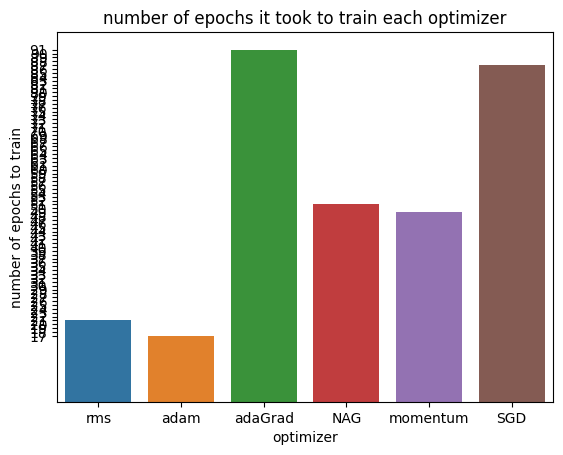

In [ ]:
# plot of number of epochs it took to train each optimizer

nums = []
names = []
for ele in num_epochs_dict:
    if(ele == 'VGD'): continue
    names.append(ele)
    nums.append(num_epochs_dict[ele])
data = pd.DataFrame({'num': nums, 'names': names})
ax = sns.barplot(x = names, y = nums)

# Set y-axis limits to integers
ax.set_yticks(range(int(min(nums)), int(max(nums))+1))

# Show the plot
ax.set_title('number of epochs it took to train each optimizer')
ax.set_xlabel('optimizer')
ax.set_ylabel('number of epochs to train')
plt.show()

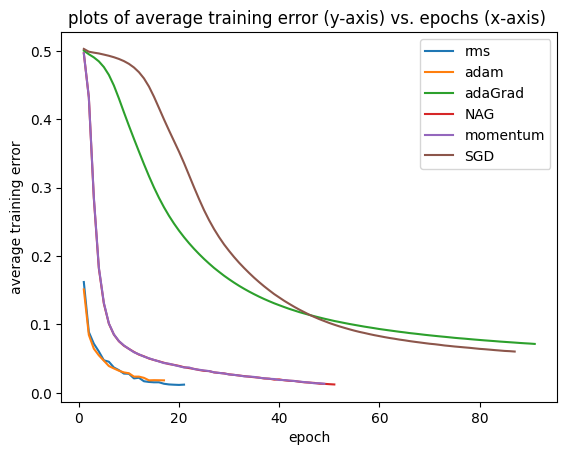

In [ ]:
# plot of loss vs epoch for each optimizer
for opt in loss_dict:
    if(opt=='VGD'):continue
    plt.plot([i for i in range(1, num_epochs_dict[opt]+1)], loss_dict[opt], label = opt)
plt.title('plots of average training error (y-axis) vs. epochs (x-axis) ')
plt.xlabel('epoch')
plt.ylabel('average training error')
plt.legend()
plt.show()

In [ ]:
# plot of accuracies of each optimizer
# Heights of the bars
opts = list(eval_dict.keys())
bar1 = (eval_dict[opt][0] for opt in opts)
bar2 = (eval_dict[opt][1] for opt in opts)

# Positions of the bars on the x-axis
x_pos = range(len(bar1))

# Set up the figure and axis objects
fig, ax = plt.subplots()

# Plot the bars
ax.bar(x_pos, bar1, width=0.4, color='b', label='training accuracy')
ax.bar([i + 0.4 for i in x_pos], bar2, width=0.4, color='g', label='validation accuracy')

# Set the x-axis labels and title
ax.set_xticks(x_pos)
ax.set_xticklabels(opts)
ax.set_xlabel('optimizer')
ax.set_ylabel('accuracy')
ax.set_title('plot of accuracies of each optimizer')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

TypeError: object of type 'generator' has no len()